In [1]:
import os
os.chdir('/kaggle/input/music-utils')
import myutils
from myutils import * # User defined functions
import music_utils
from music_utils import * # importing all the required modules and user functions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 34.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2


2024-03-19 23:13:35.282929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 23:13:35.283113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 23:13:35.466436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Loading Data and Parsing Data

#### Getting Notes and Chords from the music data

In [5]:
# file_path = "/kaggle/input/classical-music-midi/beeth/"
# notes_chords = get_notes_and_chords(file_path)
# write_file_to_pickle('/kaggle/working/notes_chords.pkl', notes_chords)

In [7]:
notes_chords = load_file_from_pickle('/kaggle/input/music-utils/beeth_notes_chords.pkl')

In [10]:
print("total number of melodies = ", len(notes_chords))

total number of melodies =  29


Making a dataset of features and labels from above obatined notes and chords.

In [12]:
length = 30
features, labels = make_dataset(notes_chords, length)

In [13]:
features[0], labels[0]

(array(['D4', 'E-4', 'F4', 'A4:G4', 'F4', 'G4', 'A4', 'B-4', 'F4', 'A4:G4',
        'F4', 'G4', 'A4', 'B-4', 'A4', 'B-4', 'C5', 'D5', 'E5', 'B-4:E5',
        'A4:F5', 'F5:E-5', 'D5', 'E-5', 'F5', 'G5', 'C5', 'D5:C5', 'B4',
        'C5'], dtype='<U29'),
 'D5')

Getting all notes and chords in a single array

In [11]:
all_notes = np.concatenate((features.ravel(), labels))

Getting unique notes and chords

In [12]:
len(all_notes) # 890934
unique_notes = np.unique(all_notes)
len(unique_notes) # 3954
print("Number of unique notes or chords in the corpus: ", len(unique_notes))

Number of unique notes or chords in the corpus:  3954


In [17]:
sorted_notes = np.sort(unique_notes)
mapping_numbers = np.arange(1, len(unique_notes)+1, 1)

In [18]:
len(mapping_numbers) # 3954
norm_map_numbers = (mapping_numbers - min(mapping_numbers))/(max(mapping_numbers)-min(mapping_numbers))

In [19]:
norm_map_numbers = norm_map_numbers + 0.01

Mapping notes and chords to values from 0.01 and 1.01

In [20]:
mapping = dict(zip(sorted_notes, norm_map_numbers))
reverse_mapping = dict(zip(norm_map_numbers, sorted_notes))

Changing the notes strings to normalized numbers using the mapping

In [21]:
features_norm = [mapping[note] for note in features.ravel()]
features_norm = np.array(features_norm).reshape((-1, length))

One hot encoding labels

In [23]:
labels_encoded, labels_mapping, labels_reverse_mapping = ohe_labels(labels)

In [24]:
features_norm.shape, labels_encoded.shape

((80414, 30), (80414, 3916))

In [25]:
x_train, x_seed, y_train, y_seed = train_test_split(features_norm, labels_encoded, test_size=0.01, random_state=42)

In [26]:
x_train = x_train.reshape((-1, length, 1))

Splitting the dataset into training and seeding

In [29]:
len(x_seed)

805

In [30]:
len(x_train)

79609

Building the model and training the model

Building the model

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [32]:
model = Sequential()
model.add(LSTM(len(mapping_numbers)//4, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Dense(448))
model.add(BatchNormalization())
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam')

callbacks = [EarlyStopping(
                monitor="loss",
                min_delta=0.002,
                patience=10,
                verbose=1,
                mode="auto",
                baseline=None,
                restore_best_weights=True,
            ),
                ReduceLROnPlateau(
                monitor="loss",
                factor=0.1,
                patience=4,
                verbose=1,
                mode="auto",
                min_delta=0.01,
                cooldown=0,
                min_lr=1e-9
            )]

Compiling the model 

Setting the Callbacks

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 988)               3912480   
                                                                 
 dense (Dense)               (None, 512)               506368    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 448)               229824    
                                                                 
 batch_normalization_1 (Bat  (None, 448)               1792      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 3916)              1

Training the model

In [34]:
num_epochs = 200
history = model.fit(x_train, y_train, batch_size=96,epochs=num_epochs, callbacks=callbacks, verbose=1)

Epoch 1/200


I0000 00:00:1710623317.587862     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


830/830 [==============================] - 27s 27ms/step - loss: 6.0616 - lr: 0.0010
Epoch 2/200
830/830 [==============================] - 23s 28ms/step - loss: 5.4761 - lr: 0.0010
Epoch 3/200
830/830 [==============================] - 23s 28ms/step - loss: 5.2947 - lr: 0.0010
Epoch 4/200
830/830 [==============================] - 24s 29ms/step - loss: 5.1390 - lr: 0.0010
Epoch 5/200
830/830 [==============================] - 24s 29ms/step - loss: 4.9851 - lr: 0.0010
Epoch 6/200
830/830 [==============================] - 25s 30ms/step - loss: 4.8034 - lr: 0.0010
Epoch 7/200
830/830 [==============================] - 25s 30ms/step - loss: 4.5712 - lr: 0.0010
Epoch 8/200
830/830 [==============================] - 25s 30ms/step - loss: 4.2320 - lr: 0.0010
Epoch 9/200
830/830 [==============================] - 25s 30ms/step - loss: 3.7913 - lr: 0.0010
Epoch 10/200
830/830 [==============================] - 25s 30ms/step - loss: 3.3286 - lr: 0.0010
Epoch 11/200
830/830 [===================

Plotting training loss vs epoch curve

In [35]:
# name = "beeth"
# import matplotlib.pyplot as plt
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(train_loss) + 1)
# plt.plot(epochs, train_loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
# plt.savefig(f'{name}_{length}.png')

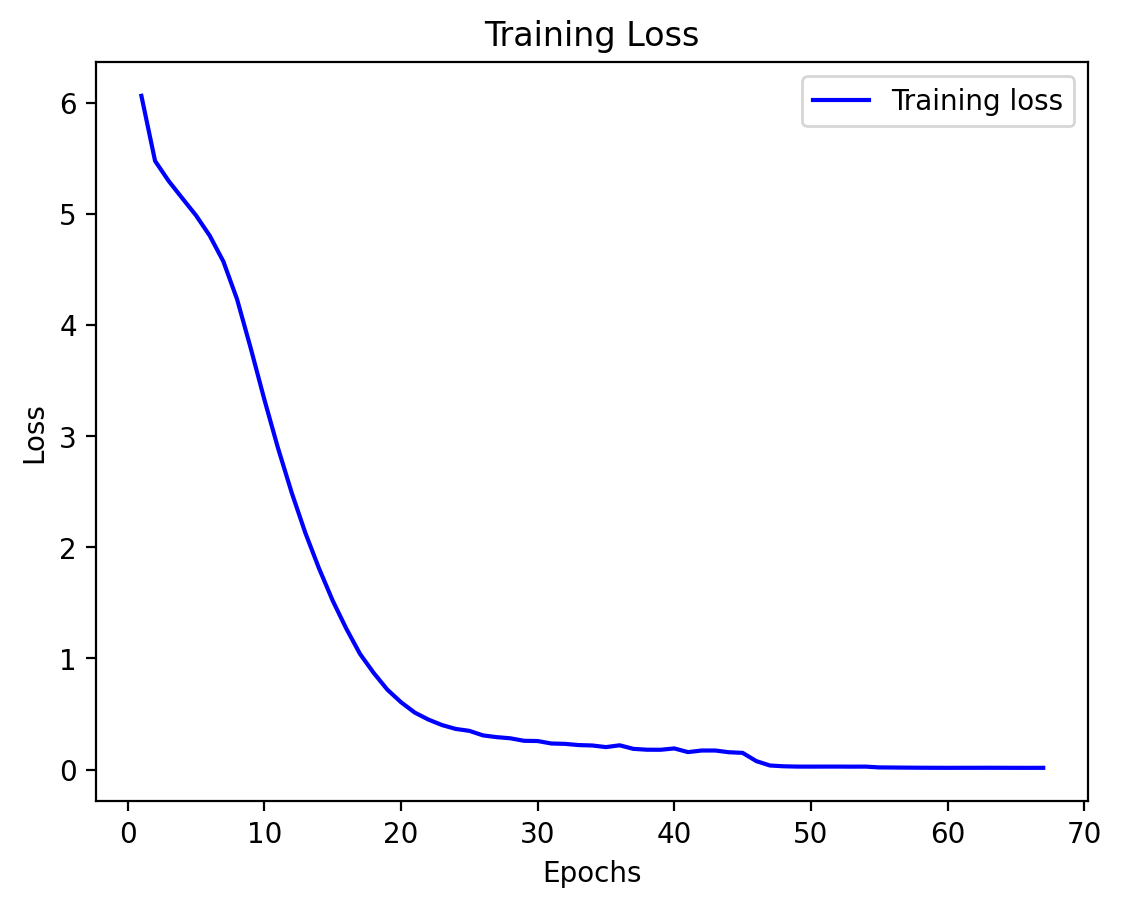

<Figure size 640x480 with 0 Axes>

In [36]:
name = "beeth"
import matplotlib.pyplot as plt
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig(f'{name}_{length}.png')

Generating music using the seed split

In [ ]:
generator = Generator(model, x_seed, mapping=mapping, reverse_mapping=reverse_mapping, labels_reverse_mapping=labels_reverse_mapping, name="Beeth")

Saving the model

In [ ]:
melody = generator.generate_melody_rand(500)
generator.save_melodies()

In [ ]:
count = 0
note_count = 200
num_songs = 2
generator.create_playlist(num_songs, note_count, direc_name = f"music{count}", zip_file=True)
count+=1